In [2]:
import plumed
import matplotlib.pyplot as plt
import os
import MDAnalysis
import mdtraj as md 
import numpy as np
import math


/usr/local/anaconda3/envs/plumed/lib/python3.9/site-packages/MDAnalysis/coordinates/chemfiles.py:108: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  MIN_CHEMFILES_VERSION = LooseVersion("0.9")
/usr/local/anaconda3/envs/plumed/lib/python3.9/site-packages/MDAnalysis/coordinates/TRJ.py:1209: DeprecationWarning: Please use `netcdf_file` from the `scipy.io` namespace, the `scipy.io.netcdf` namespace is deprecated.
  class NCDFPicklable(scipy.io.netcdf.netcdf_file):


In [271]:
def plotmed(cv):
   
    df = [plumed.read_as_pandas(i) for i in cv]
    arr = [i.to_numpy() for i in df]
    cat = np.concatenate(arr,axis=0)
    cat[~np.isfinite(cat)] = 0
    title = df[0].columns.tolist()
   
    fig,ax = plt.subplots(1,1,figsize=(10,10))
    pyemma.plots.plot_free_energy(*cat[:,1:3].T,ax=ax)
    ax.set_xlabel("{}".format(title[1]))
    ax.set_ylabel("{}".format(title[2]))
    ax.set_title("phi,psi")
   
    if len(cv)>=5:
        fig,ax = plt.subplots(1,1,figsize=(10,10))
        pyemma.plots.plot_free_energy(*cat[:,3:5].T,ax=ax)
        ax.set_xlabel("{}".format(title[3]))
        ax.set_ylabel("{}".format(title[4]))
   
    for i,t in enumerate(title):
        plt.figure()
        for j in df:
            j.iloc[:,i].plot(xlabel="Time",ylabel=t)
           
    fig,ax=plt.subplots(len(title),1, figsize=(8,2.5*len(title)))
    for i,(t,ax) in enumerate(zip(title,ax.flat)):
        sns.kdeplot(cat[:,i],ax=ax)
        ax.set_xlabel(f"{t}")
        plt.tight_layout()
   
    return df,arr,cat

This notebook is entirely based on /indebted to the wonderful material from the PLUMED masterclass:

https://www.plumed.org/doc-v2.7/user-doc/html/masterclass-21-4.html

And we thank the authors of the PLUMED software for sharing all of their material opensource

In [9]:
# set working directory for all future cells
# exercise_dir='/Users/paulrobustelli/Desktop/CHEM.101.6/Lab5_MetaDynamics/Project5_Student_Test/'
# os.chdir(exercise_dir)
# and check with bash command pwd - note the exclamation mark at the beginning
!pwd
# or in python
exercise_dir=os.getcwd()


/Users/tommysisk/CHEM101/CHEM101.6Exercise-1/run_B


In [10]:
if not os.path.exists(exercise_dir+'Exercise-1'):
    os.makedirs(exercise_dir+'Exercise-1')
os.chdir(exercise_dir+'Exercise-1')

In this exercise we're going to perform simulations of the alanine dipeptide
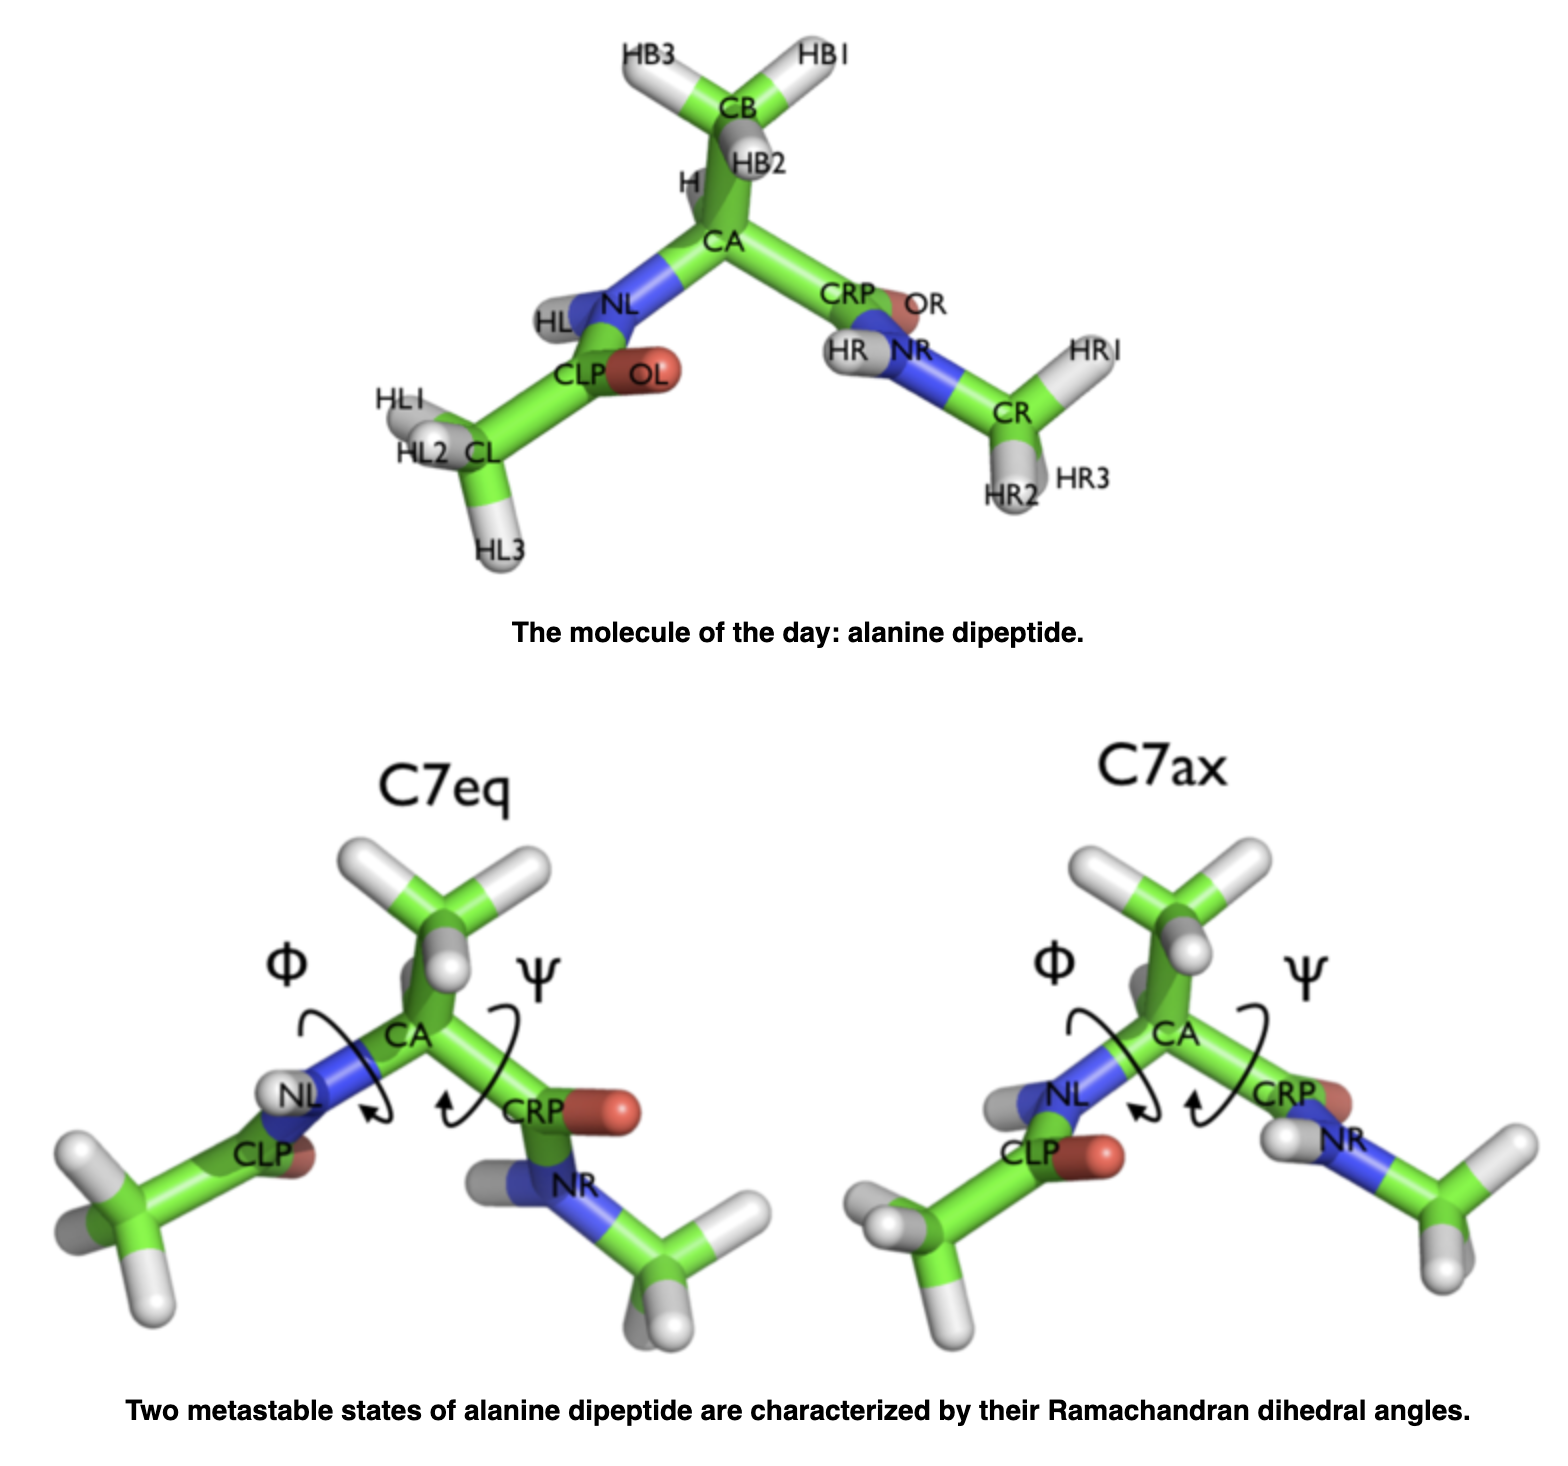

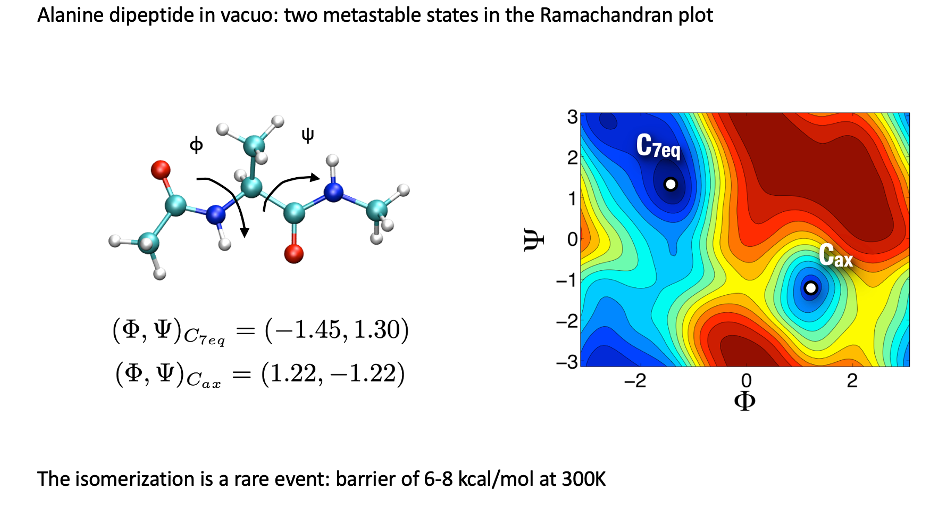

We're going to run simulations of the alanine dipeptide in gromacs, and analyze the simulations with software PLUMED

www.plumed.org

PLUMED is an enhanced sampling plugin that works with many different MD packages to perform enhanced sampling calculations.

Below is an example of plumed input file, which gives PLUMED a reference structure, and tells it what values to analyze (or bias) from the simulation based on that reference structure.  That is a cell that can write out a plumed.dat input file 

#plumed.dat input file

\# Activate MOLINFO functionalities

MOLINFO STRUCTURE=../../data/diala/dialaA.pdb 

\# Compute the backbone dihedral angle phi, defined by atoms C-N-CA-C

\# you should use MOLINFO shortcuts

phi: TORSION ATOMS=@phi-2 

\# Compute the backbone dihedral angle psi, defined by atoms N-CA-C-N

\# here also you should to use MOLINFO shortcuts

psi: TORSION ATOMS=@psi-2 

\# Print the two collective variables on COLVAR file every step
PRINT ARG=phi,psi FILE=COLVAR STRIDE=1 
EOF

In [11]:
%%bash
# prepare PLUMED input file for analysis
cat > "plumed.dat" << EOF
# Activate MOLINFO functionalities
MOLINFO STRUCTURE=../../data/diala/dialaA.pdb 
# Compute the backbone dihedral angle phi, defined by atoms C-N-CA-C
# you should use MOLINFO shortcuts
phi: TORSION ATOMS=@phi-2 
# Compute the backbone dihedral angle psi, defined by atoms N-CA-C-N
# here also you should to use MOLINFO shortcuts
psi: TORSION ATOMS=@psi-2 
# Print the two collective variables on COLVAR file every step
PRINT ARG=phi,psi FILE=COLVAR STRIDE=1 
EOF

In [12]:
if not os.path.exists('run_A'):
 os.mkdir('run_A')
if not os.path.exists('run_B'):
 os.mkdir('run_B')
os.chdir('run_A')

Here we are going to run gromacs starting from the first reference structure of alanine dipeptide and then run the plumed "driver"

The plumed driver analyses a trajectory after the fact, and computes the collective variables specified in the plumed.dat file for that trajectory

In [14]:
!gmx mdrun -s ../../data/diala/topolA.tpr -nsteps 10000000 
!plumed driver --plumed ../plumed.dat --mf_xtc traj_comp.xtc
os.chdir('../run_B')

                      :-) GROMACS - gmx mdrun, 2019.6 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf   
                           and the project leaders:
        Mark Abraham, Ber

Now we do the same for the other reference structure

In [15]:
#%%bash
!gmx mdrun -s ../../data/diala/topolB.tpr -nsteps 10000000
!plumed driver --plumed ../plumed.dat --mf_xtc traj_comp.xtc


                      :-) GROMACS - gmx mdrun, 2019.6 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf   
                           and the project leaders:
        Mark Abraham, Ber

In [18]:
os.chdir("/Users/tommysisk/CHEM101/CHEM101.6Exercise-1")

In [19]:
#Here we are going to read the plumed COLVAR (Collective Variable) files as pandas dataframes
# import PLUMED COLVAR files into pandas datasets
dataA=plumed.read_as_pandas("Exercise-1/run_A/COLVAR")
dataB=plumed.read_as_pandas("Exercise-1/run_B/COLVAR")
dataA

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/usr/local/anaconda3/envs/plumed/lib/libplumedKernel.dylib" +++
+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/usr/local/anaconda3/envs/plumed/lib/libplumedKernel.dylib" +++


time       phi       psi
0            0.0 -1.257768  2.877951
1            1.0 -2.714986  2.432860
2            2.0 -2.332921  2.672415
3            3.0 -2.010501  2.706560
4            4.0 -1.848329  2.401884
...          ...       ...       ...
99996    99996.0 -1.786034  2.540751
99997    99997.0 -1.740870  2.585592
99998    99998.0 -1.722899  2.059260
99999    99999.0 -1.290314  2.212053
100000  100000.0 -1.537746  2.129950

[100001 rows x 3 columns]

Std phi run_A: 0.5532909817219714
Std phi run_B: 0.1317100551971834


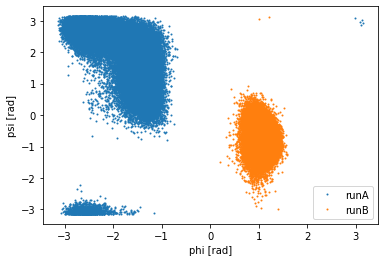

In [20]:
#Here we are going to read the plumed COLVAR (Collective Variable) files as pandas dataframes
# plot phi vs psi
plt.plot(dataA["phi"],dataA["psi"],'o',ms=1, label="runA")
plt.plot(dataB["phi"],dataB["psi"],'o',ms=1, label="runB")
# x-y axis labels
plt.xlabel("phi [rad]")
plt.ylabel("psi [rad]")
plt.legend()
# calculate Gaussian sigma
print("Std phi run_A:",np.std(dataA["phi"]))
print("Std phi run_B:",np.std(dataB["phi"]))

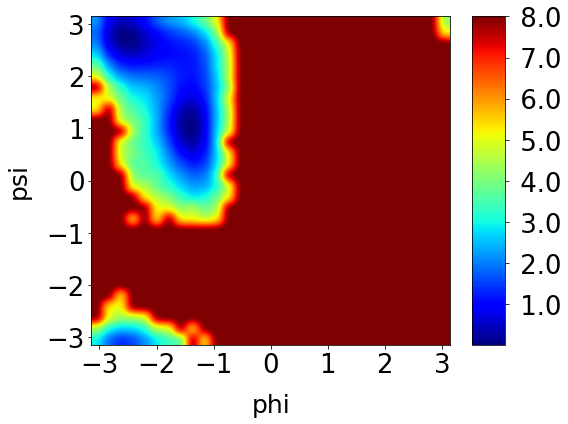

<Figure size 432x288 with 0 Axes>

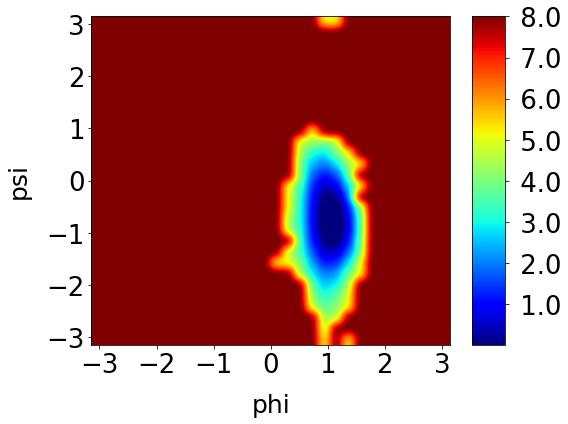

In [21]:
#Lets Plot the Free Energy Surfaces of Each Simulation
def free_energy(a, b, T, y0, ymax, x0, xmax):
    free_energy, xedges, yedges = np.histogram2d(
        a, b, 30, [[y0, ymax], [x0, xmax]], normed=True, weights=None)
    free_energy = np.log(np.flipud(free_energy)+.000001)
    free_energy = -(0.001987*T)*free_energy
    return free_energy, xedges, yedges


dG,xedges,yedges=free_energy(dataA["psi"],dataA["phi"], 300, -3.14, 3.14, -3.14, 3.14)

fig = plt.figure(figsize=(8, 6))
im = plt.imshow(dG, interpolation='gaussian', extent=[
                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')
cbar_ticks = [0, 1, 2, 3, 4, 5,6,7,8]
plt.xlim(-3.14,3.14)
plt.ylim(-3.14,3.14)

cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'),
                  aspect=10)  # grab the Colorbar instance
imaxes = plt.gca()
plt.ylabel("psi", size=25, labelpad=15)
plt.xlabel("phi", size=25, labelpad=15)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.xticks(size='26')
plt.yticks(size='26')
plt.axes(cb.ax)
plt.clim(vmin=0.01, vmax=8.0)
plt.yticks(size='26')
plt.tight_layout()
plt.show()
plt.clf()


dG,xedges,yedges=free_energy(dataB["psi"],dataB["phi"], 300, -3.14, 3.14, -3.14, 3.14)

fig = plt.figure(figsize=(8, 6))
im = plt.imshow(dG, interpolation='gaussian', extent=[
                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')
cbar_ticks = [0, 1, 2, 3, 4, 5,6,7,8]
plt.xlim(-3.14,3.14)
plt.ylim(-3.14,3.14)

cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'),
                  aspect=10)  # grab the Colorbar instance
imaxes = plt.gca()
plt.ylabel("psi", size=25, labelpad=15)
plt.xlabel("phi", size=25, labelpad=15)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.xticks(size='26')
plt.yticks(size='26')
plt.axes(cb.ax)
plt.clim(vmin=0.01, vmax=8.0)
plt.yticks(size='26')
plt.tight_layout()
plt.show()

Now We're going to run a metadynamics simulation biasing the phi dihedral angle.  First Lets remind ourselves of the key equation

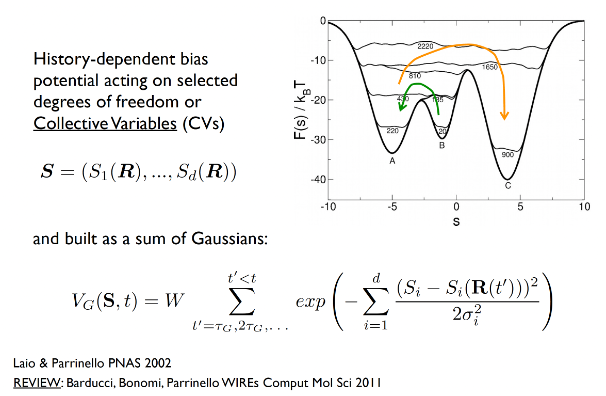

We now generate a plumed.dat file and define the key parameters for our simulation (Pace, Height, and Biasfactor)


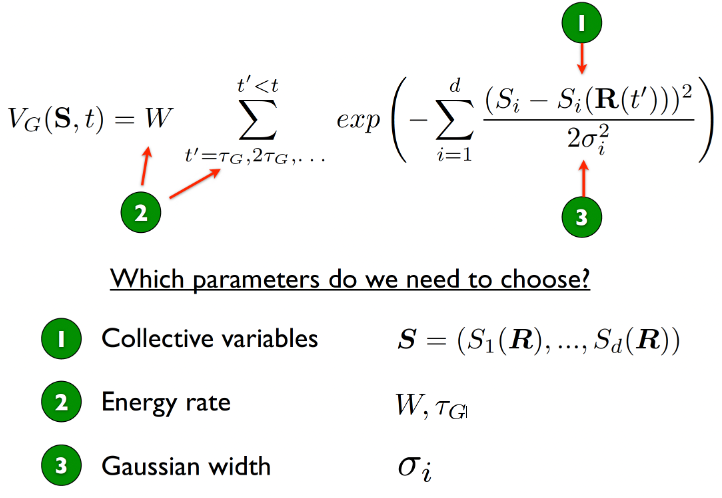

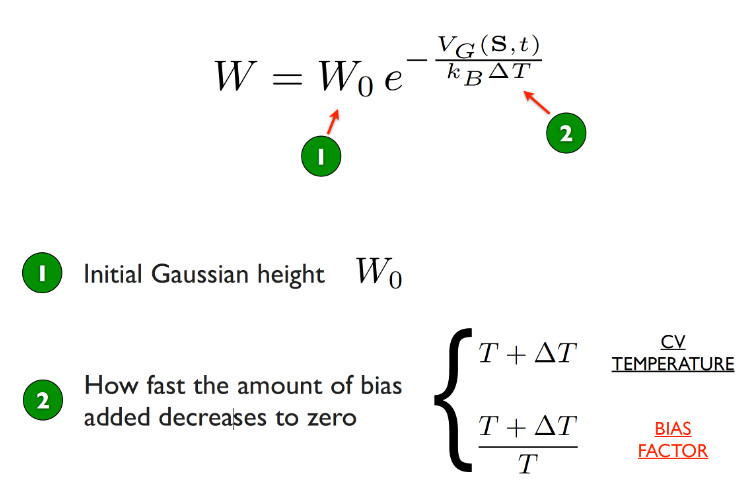

In [22]:
os.getcwd()

'/Users/tommysisk/CHEM101/CHEM101.6Exercise-1'

In [23]:
%%bash
# Exercise 2
# create directory for this exercise
mkdir Exercise-2; cd Exercise-2
# create PLUMED input file
cat > "plumed.dat" << EOF
# Activate MOLINFO functionalities
MOLINFO STRUCTURE=../data/diala/dialaA.pdb 
# Compute the backbone dihedral angle phi, defined by atoms C-N-CA-C
# you should use MOLINFO shortcuts
phi: TORSION ATOMS=@phi-2 
# Compute the backbone dihedral angle psi, defined by atoms N-CA-C-N
# here also you should to use MOLINFO shortcuts
psi: TORSION ATOMS=@psi-2 
# Activate well-tempered metadynamics in phi
metad: METAD ARG=phi ...
   # Deposit a Gaussian every 500 time steps, with initial height 
   # equal to 1.2 kJ/mol and bias factor equal to 8 
   PACE=500 HEIGHT=1.2 BIASFACTOR=8 
   # Gaussian width (sigma) should be chosen based on the CV fluctuations in unbiased run 
   SIGMA=0.3 
   # Gaussians will be written to file and also stored on grid 
   FILE=HILLS GRID_MIN=-pi GRID_MAX=pi 
...
# Print both collective variables on COLVAR file every 10 steps
PRINT ARG=phi,psi FILE=COLVAR STRIDE=10   
EOF

# run simulation
gmx mdrun -s ../data/diala/topolA.tpr -nsteps 10000000 -plumed plumed.dat

                      :-) GROMACS - gmx mdrun, 2019.6 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf   
                           and the project leaders:
        Mark Abraham, Ber

During the metadynamics simulation, PLUMED will create two files, named COLVAR and HILLS. The COLVAR file contains all the information specified by the PRINT command, in this case the value of the backbone dihedrals ϕ and ψ every 10 steps of simulation. The HILLS file contains a list of the Gaussian kernels deposited along the simulation.

Let's visualize the time series of the two collective variables. Take your time to inspect the behavior of the two CVs. What are the main differences with respect to the trajectory produced in Exercise 1: Familiarizing with alanine dipeptide ?

At this point, we can estimate the free energy as a function of the metadynamics CV directly from the metadynamics bias potential. In order to do so, the utility sum_hills can be used to sum the Gaussian kernels deposited during the simulation and stored in the HILLS file.
To calculate the free energy as a function of ϕ, it is sufficient to use the following command line:

In [24]:
# visualize CV file
data=plumed.read_as_pandas("Exercise-2/COLVAR")
data

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/usr/local/anaconda3/envs/plumed/lib/libplumedKernel.dylib" +++


time       phi       psi
0            0.00 -1.256671  2.876745
1            0.02 -1.145859  2.904935
2            0.04 -1.442618  2.958939
3            0.06 -1.408497  3.115773
4            0.08 -1.625169  2.966878
...           ...       ...       ...
999996   19999.92 -1.476788  2.550682
999997   19999.94 -1.623941  2.561712
999998   19999.96 -1.792589  2.511435
999999   19999.98 -2.039875  2.432516
1000000  20000.00 -2.122905  2.385191

[1000001 rows x 3 columns]

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/usr/local/anaconda3/envs/plumed/lib/libplumedKernel.dylib" +++


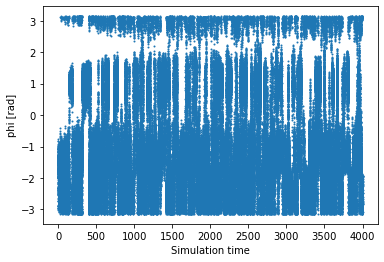

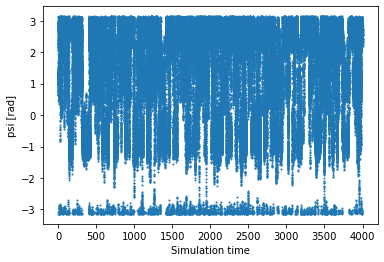

In [25]:
# visualize CV file
data=plumed.read_as_pandas("Exercise-2/COLVAR")
# plot phi during simulation (first 200k points)
plt.plot(data["time"][:200000],data["phi"][:200000],'o', ms=1)
# x-y axis labels
plt.xlabel("Simulation time")
plt.ylabel("phi [rad]")
plt.show()
plt.clf()

plt.plot(data["time"][:200000],data["psi"][:200000],'o', ms=1)
# x-y axis labels
plt.xlabel("Simulation time")
plt.ylabel("psi [rad]")
plt.show()

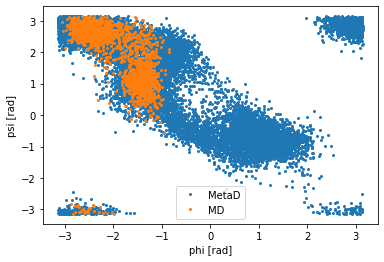

In [26]:
#Now we compare the structures sampled in the biased vs. unbiased simulations
# plot phi vs psi
# plot phi vs psi
plt.plot(data["phi"][::50],data["psi"][::50],'o', ms=2,   label="MetaD")
plt.plot(dataA["phi"][::50],dataA["psi"][::50],'o', ms=2, label="MD")
# x-y axis labels
plt.xlabel("phi [rad]")
plt.ylabel("psi [rad]")
plt.legend()

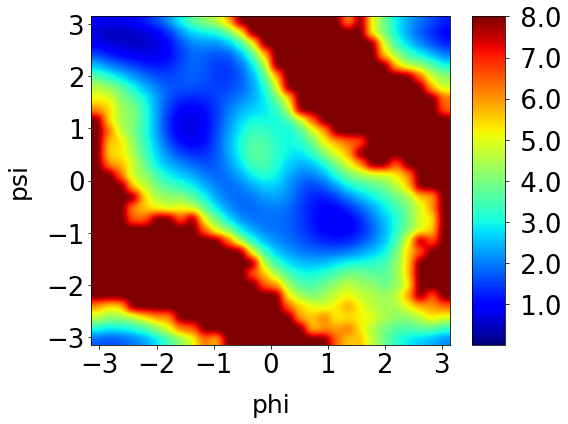

<Figure size 432x288 with 0 Axes>

In [27]:
#Lets Look at The Biased Distribution of Dihedral Angles
dG,xedges,yedges=free_energy(data["psi"],data["phi"], 300, -3.14, 3.14, -3.14, 3.14)

fig = plt.figure(figsize=(8, 6))
im = plt.imshow(dG, interpolation='gaussian', extent=[
                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')
cbar_ticks = [0, 1, 2, 3, 4, 5,6,7,8]
plt.xlim(-3.14,3.14)
plt.ylim(-3.14,3.14)

cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'),
                  aspect=10)  # grab the Colorbar instance
imaxes = plt.gca()
plt.ylabel("psi", size=25, labelpad=15)
plt.xlabel("phi", size=25, labelpad=15)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.xticks(size='26')
plt.yticks(size='26')
plt.axes(cb.ax)
plt.clim(vmin=0.01, vmax=8.0)
plt.yticks(size='26')
plt.tight_layout()
plt.show()
plt.clf()

At this point, we can estimate the free energy as a function of the metadynamics CV directly from the metadynamics bias potential. In order to do so, the utility sum_hills can be used to sum the Gaussian kernels deposited during the simulation and stored in the HILLS file.

To avoid descretization errors with large bins in a histogram Sum Hills essentially uses a kernel density estimate to add the gaussians onto a grid.

https://www.plumed.org/doc-v2.7/user-doc/html/sum_hills.html

To calculate the free energy as a function of ϕ, it is sufficient to use the following command line:

plumed sum_hills --hills HILLS --stride 200 --mintozero

The command above generates a file called fes.dat in which the free-energy surface as function of ϕ is calculated on a regular grid.

We're going to calculate the sum of the gaussians, and convert that to a free energy, at different points in the simulation to see if things have converged

In [28]:
%%bash
# compute free energy as a function of simulation time
cd Exercise-2
plumed sum_hills --hills HILLS --stride 200 --mintozero

PLUMED: PLUMED is starting
PLUMED: Version: 2.7.3 (git: Unknown) compiled on Dec  1 2021 at 12:56:28
PLUMED: Please cite these papers when using PLUMED [1][2]
PLUMED: For further information see the PLUMED web page at http://www.plumed.org
PLUMED: Root: /usr/local/anaconda3/envs/plumed/lib/plumed
PLUMED: For installed feature, see /usr/local/anaconda3/envs/plumed/lib/plumed/src/config/config.txt
PLUMED: Molecular dynamics engine: 
PLUMED: Precision of reals: 8
PLUMED: Running over 1 node
PLUMED: Number of threads: 1
PLUMED: Cache line size: 512
PLUMED: Number of atoms: 1
PLUMED: File suffix: 
PLUMED: Timestep: 0.000000
PLUMED: KbT has not been set by the MD engine
PLUMED: It should be set by hand where needed
PLUMED: Relevant bibliography:
PLUMED:   [1] The PLUMED consortium, Nat. Methods 16, 670 (2019)
PLUMED:   [2] Tribello, Bonomi, Branduardi, Camilloni, and Bussi, Comput. Phys. Commun. 185, 604 (2014)
PLUMED: Please read and cite where appropriate!
PLUMED: Finished setup
PLUMED: Ac

PLUMED:   done with this chunk: now with 7800 kernels  
PLUMED: 
PLUMED:   Writing full grid on file fes_38.dat 
PLUMED:   reading hills: 
PLUMED:   doing serialread 
PLUMED:   done with this chunk: now with 8000 kernels  
PLUMED: 
PLUMED:   Writing full grid on file fes_39.dat 
PLUMED:   reading hills: 
PLUMED:   doing serialread 
PLUMED:   done with this chunk: now with 8200 kernels  
PLUMED: 
PLUMED:   Writing full grid on file fes_40.dat 
PLUMED:   reading hills: 
PLUMED:   doing serialread 
PLUMED:   done with this chunk: now with 8400 kernels  
PLUMED: 
PLUMED:   Writing full grid on file fes_41.dat 
PLUMED:   reading hills: 
PLUMED:   doing serialread 
PLUMED:   done with this chunk: now with 8600 kernels  
PLUMED: 
PLUMED:   Writing full grid on file fes_42.dat 
PLUMED:   reading hills: 
PLUMED:   doing serialread 
PLUMED:   done with this chunk: now with 8800 kernels  
PLUMED: 
PLUMED:   Writing full grid on file fes_43.dat 
PLUMED:   reading hills: 
PLUMED:   doing serialread

PLUMED:   doing serialread 
PLUMED:   done with this chunk: now with 17600 kernels  
PLUMED: 
PLUMED:   Writing full grid on file fes_87.dat 
PLUMED:   reading hills: 
PLUMED:   doing serialread 
PLUMED:   done with this chunk: now with 17800 kernels  
PLUMED: 
PLUMED:   Writing full grid on file fes_88.dat 
PLUMED:   reading hills: 
PLUMED:   doing serialread 
PLUMED:   done with this chunk: now with 18000 kernels  
PLUMED: 
PLUMED:   Writing full grid on file fes_89.dat 
PLUMED:   reading hills: 
PLUMED:   doing serialread 
PLUMED:   done with this chunk: now with 18200 kernels  
PLUMED: 
PLUMED:   Writing full grid on file fes_90.dat 
PLUMED:   reading hills: 
PLUMED:   doing serialread 
PLUMED:   done with this chunk: now with 18400 kernels  
PLUMED: 
PLUMED:   Writing full grid on file fes_91.dat 
PLUMED:   reading hills: 
PLUMED:   doing serialread 
PLUMED:   done with this chunk: now with 18600 kernels  
PLUMED: 
PLUMED:   Writing full grid on file fes_92.dat 
PLUMED:   reading 

Now we use the PLUMED python wrapper to extract the free energies calculated by SUM HILLS.

We have outputed the collected free energy at each phase of the simulation, so we can see the free energy as a function of the number of gausians deposited 

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/usr/local/anaconda3/envs/plumed/lib/libplumedKernel.dylib" +++
+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/usr/local/anaconda3/envs/plumed/lib/libplumedKernel.dylib" +++
+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/usr/local/anaconda3/envs/plumed/lib/libplumedKernel.dylib" +++
+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/usr/local/anaconda3/envs/plumed/lib/libplumedKernel.dylib" +++
+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/usr/local/anaconda3/envs/plumed/lib/libplumedKernel.dylib" +++
+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/usr/local/anaconda3/envs/plumed/lib/libplumedKernel.dylib" +++
+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/usr/local/anaconda3/envs/plumed/lib/libplumedKernel.dylib" +++
+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/usr/local/anaconda3/envs/plumed/lib/libplumedKernel.dylib" +++


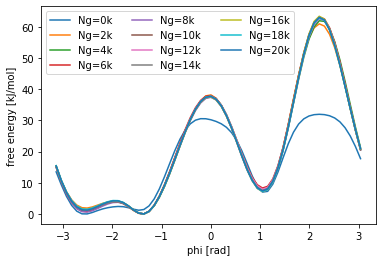

In [29]:
# plot free energy as a function of simulation time
for i in range(0,101,10):   
 # import fes file into pandas dataset
 data=plumed.read_as_pandas("Exercise-2/fes_"+str(i)+".dat")
 # plot fes
 plt.plot(data["phi"],data["file.free"], label="Ng="+str(int(2*i/10))+"k") 
# labels
plt.xlabel("phi [rad]")
plt.ylabel("free energy [kJ/mol]")
plt.legend(ncol=3)

We Can see that torwards the end of the simulation, free energies are fairly constant, suggesting we may have converged.

Now lets calculate the free energy difference between our two states

In [30]:
# calculate free-energy difference
DeltaF=[]; kbt=2.494339
# cycle on free-energy profiles
for i in range(0,101):   
 # import fes file into pandas dataset
 data=plumed.read_as_pandas("Exercise-2/fes_"+str(i)+".dat")
 # find minimum value of fes
 minf = min(data["file.free"])
 # plot fes
 F0=0.0; F1=0.0
 for j in range(0, len(data["phi"])):
     phi = data["phi"][j]
     # calculate probability
     p = math.exp((-data["file.free"][j]+minf)/kbt)
     # integrate in the two basins
     if(-3<=phi<=-1):   F0 += p
     if(0.5<=phi<=1.5): F1 += p
 # calculate free energy difference and add to list
 DeltaF.append(-kbt*math.log(F0/F1))         


+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/usr/local/anaconda3/envs/plumed/lib/libplumedKernel.dylib" +++
+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/usr/local/anaconda3/envs/plumed/lib/libplumedKernel.dylib" +++
+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/usr/local/anaconda3/envs/plumed/lib/libplumedKernel.dylib" +++
+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/usr/local/anaconda3/envs/plumed/lib/libplumedKernel.dylib" +++
+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/usr/local/anaconda3/envs/plumed/lib/libplumedKernel.dylib" +++
+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/usr/local/anaconda3/envs/plumed/lib/libplumedKernel.dylib" +++
+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/usr/local/anaconda3/envs/plumed/lib/libplumedKernel.dylib" +++
+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/usr/local/anaconda3/envs/plumed/lib/libplumedKernel.dylib" +++


Text(0, 0.5, 'DeltaF [kJ/mol]')

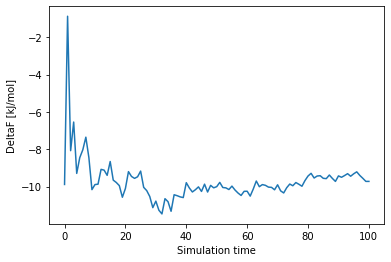

In [31]:
# plot
plt.plot(DeltaF) 
# labels
plt.xlabel("Simulation time")
plt.ylabel("DeltaF [kJ/mol]")

Now we're ging to reweight (or "unbias") or metadynamics simulation to calculate free energies as a function of other collective variables that we didn't bias (like psi)

We're going to do this following: 

https://pubs.acs.org/doi/abs/10.1021/ct3002464

Where we calculate the bias potential obtained at the end of the simulation and assuming a constant bias during the entire course of the simulation, similar to the way umbrella sampling simulations are unbiased.


We do this using the PLUMED functions histogram and convert_to_fes


https://www.plumed.org/doc-v2.7/user-doc/html/_c_o_n_v_e_r_t__t_o__f_e_s.html


https://www.plumed.org/doc-v2.7/user-doc/html/_h_i_s_t_o_g_r_a_m.html


As a result, PLUMED will produce a new COLVAR_REWEIGHT file with one additional column containing the metadynamics bias potential V(s) calculated using all the Gaussians deposited along the entire trajectory. You can easily obtain the weight w of each frame using the expression w∝exp(V(s)kBT) (umbrella-sampling-like reweighting). At this point, you can read the COLVAR_REWEIGHT file using a python notebook and compute a weighted histogram or, alternatively, if you want PLUMED to do the weighted histograms for you, you can add the following lines at the end of the plumed_reweight.dat file and re-run PLUMED driver:

In [32]:
%%bash
# Exercise 3
# create directory for this exercise
mkdir Exercise-3; cd Exercise-3

# prepare PLUMED input file for reweighting
cat > "plumed_reweight.dat" << EOF
# Activate MOLINFO functionalities
MOLINFO STRUCTURE=../data/diala/dialaA.pdb 
# Compute the backbone dihedral angle phi, defined by atoms C-N-CA-C
# you should use MOLINFO shortcuts
phi: TORSION ATOMS=@phi-2 
# Compute the backbone dihedral angle psi, defined by atoms N-CA-C-N
# here also you should to use MOLINFO shortcuts
psi: TORSION ATOMS=@psi-2 
# Activate well-tempered metadynamics in phi
metad: METAD ARG=phi ...
   # Deposit a Gaussian every 10000000 time steps (never!), with initial height equal to 0.0 kJ/mol 
   PACE=10000000 HEIGHT=0.0 BIASFACTOR=8# <- this is the new stuff! 
   # Gaussian width (sigma) should be chosen based on the CV fluctuations in unbiased run 
   SIGMA=0.3 
   # Gaussians will be written to file and also stored on grid 
   FILE=../Exercise-2/HILLS GRID_MIN=-pi GRID_MAX=pi
   # Say that METAD should be restarting (= reading an existing HILLS file) 
   RESTART=YES # <- this is the new stuff! 
...

# Use the metadynamics bias as argument
as: REWEIGHT_BIAS ARG=metad.bias 
# Calculate histograms of phi and psi dihedrals every 50 steps
# using the weights obtained from the metadynamics bias potentials (umbrella-sampling-like reweighting)
# Look at the manual to understand the parameters of the HISTOGRAM action!
hhphi: HISTOGRAM ARG=phi STRIDE=50 GRID_MIN=-pi GRID_MAX=pi GRID_BIN=50 BANDWIDTH=0.05 LOGWEIGHTS=as 
hhpsi: HISTOGRAM ARG=psi STRIDE=50 GRID_MIN=-pi GRID_MAX=pi GRID_BIN=50 BANDWIDTH=0.05 LOGWEIGHTS=as 
# Convert histograms h(s) to free energies F(s) = -kBT * log(h(s))
ffphi: CONVERT_TO_FES GRID=hhphi 
ffpsi: CONVERT_TO_FES GRID=hhpsi 
# Print out the free energies F(s) to file once the entire trajectory is processed
DUMPGRID GRID=ffphi FILE=ffphi.dat 
DUMPGRID GRID=ffpsi FILE=ffpsi.dat 

# Print out the values of phi, psi and the metadynamics bias potential
# Make sure you print out the 3 variables in the specified order at every step
PRINT ARG=phi,psi,metad.bias FILE=COLVAR_REWEIGHT STRIDE=1 # <- also change this one!
EOF

# analyze with PLUMED driver
plumed driver --mf_xtc ../Exercise-2/traj_comp.xtc --plumed plumed_reweight.dat --kt 2.494339


DRIVER: Found molfile format trajectory xtc with name ../Exercise-2/traj_comp.xtc
PLUMED: PLUMED is starting
PLUMED: Version: 2.7.3 (git: Unknown) compiled on Dec  1 2021 at 12:56:28
PLUMED: Please cite these papers when using PLUMED [1][2]
PLUMED: For further information see the PLUMED web page at http://www.plumed.org
PLUMED: Root: /usr/local/anaconda3/envs/plumed/lib/plumed
PLUMED: For installed feature, see /usr/local/anaconda3/envs/plumed/lib/plumed/src/config/config.txt
PLUMED: Molecular dynamics engine: driver
PLUMED: Precision of reals: 8
PLUMED: Running over 1 node
PLUMED: Number of threads: 1
PLUMED: Cache line size: 512
PLUMED: Number of atoms: 22
PLUMED: File suffix: 
PLUMED: FILE: plumed_reweight.dat
PLUMED: Action MOLINFO
PLUMED:   with label @0
PLUMED:   pdb file named ../data/diala/dialaA.pdb contains 1 chains 
PLUMED:   chain named   contains residues 1 to 3 and atoms 1 to 22 
PLUMED: Action TORSION
PLUMED:   with label phi
PLUMED:   between atoms 5 7 9 15
PLUMED:   u

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/usr/local/anaconda3/envs/plumed/lib/libplumedKernel.dylib" +++
+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/usr/local/anaconda3/envs/plumed/lib/libplumedKernel.dylib" +++


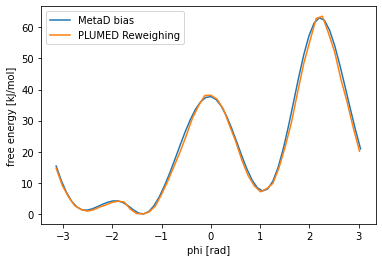

In [33]:
# now compare free energy from metadynamics bias and reweighting
data_b=plumed.read_as_pandas("Exercise-2/fes_100.dat")
data_r=plumed.read_as_pandas("Exercise-3/ffphi.dat")

# plot free energies
plt.plot(data_b["phi"],data_b["file.free"],label="MetaD bias")
plt.plot(data_r["phi"],data_r["ffphi"]-min(data_r["ffphi"]),label="PLUMED Reweighing")
# x-y axis labels
plt.xlabel("phi [rad]")
plt.ylabel("free energy [kJ/mol]")
plt.legend()

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/usr/local/anaconda3/envs/plumed/lib/libplumedKernel.dylib" +++
+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/usr/local/anaconda3/envs/plumed/lib/libplumedKernel.dylib" +++


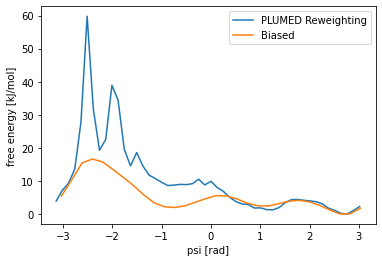

In [34]:
# now compare free energy from metadynamics bias and the unbiased ditribution 
#First lets look at our old function for making 1D free energy histograms

def free_energy_1D(a,kT,x0,xmax,bins):
  free_energy,xedges=np.histogram(a,bins=bins,range=[x0,xmax],density=True,weights=None)
  max=np.max(free_energy)  
  free_energy=np.log(free_energy+.0000001)
  free_energy=-kT*(free_energy-np.log(max+.0000001))
  xcenters= xedges[:-1] + np.diff(xedges)/2
  return free_energy,xcenters

data_r=plumed.read_as_pandas("Exercise-3/COLVAR_REWEIGHT")
data_psi=plumed.read_as_pandas("Exercise-3/ffpsi.dat")# plot free energies

plt.plot(data_psi["psi"],data_psi["ffpsi"]-min(data_psi["ffpsi"]),label="PLUMED Reweighting")
kt=2.494339
dG,centers=free_energy_1D(data_r["psi"],kt,-3.14,3.14,30)
plt.plot(centers,dG,label='Biased')

         
# x-y axis labels
plt.xlabel("psi [rad]")
plt.ylabel("free energy [kJ/mol]")
plt.legend()

***CLASS ACTIVITY***

Lets Read in the COLVAR_REWEIGHT file and reweight each CV manually

We can obtain the weight w of each frame using the  (umbrella-sampling-like reweighting) expression

w∝exp(V(s)kBT). 

At this point, you can read the COLVAR_REWEIGHT file using a python notebook and compute a weighted histogram

https://numpy.org/doc/stable/reference/generated/numpy.histogram.html


In [35]:
data_r=plumed.read_as_pandas("Exercise-3/COLVAR_REWEIGHT")
data_psi=plumed.read_as_pandas("Exercise-3/ffpsi.dat")
data_b=plumed.read_as_pandas("Exercise-2/fes_100.dat")

#LETS START BY MODIFYING OOUR free_energy_1D FUNCTION TO INCLUDE WEIGHTS


+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/usr/local/anaconda3/envs/plumed/lib/libplumedKernel.dylib" +++
+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/usr/local/anaconda3/envs/plumed/lib/libplumedKernel.dylib" +++
+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/usr/local/anaconda3/envs/plumed/lib/libplumedKernel.dylib" +++


In [51]:
#Now lets Look at The 2D Biased and Unbiased Distributions of the Dihedral Angles

def free_energy(a, b, T, y0, ymax, x0, xmax):
    free_energy, xedges, yedges = np.histogram2d(
        a, b, 30, [[y0, ymax], [x0, xmax]], normed=True, weights=None)
    free_energy = np.log(np.flipud(free_energy)+.000001)
    free_energy = -(0.001987*T)*free_energy
    return free_energy, xedges, yedges


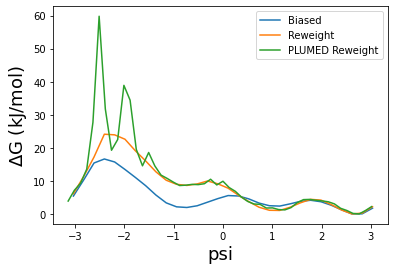

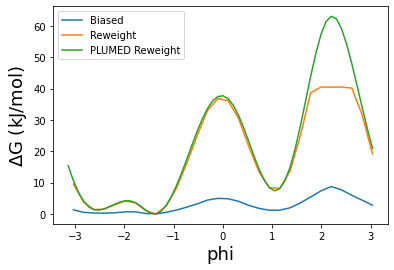

<Figure size 432x288 with 0 Axes>

In [41]:
def free_energy_1D(a,kT,x0,xmax,bins):
  free_energy,xedges=np.histogram(a,bins=bins,range=[x0,xmax],density=True,weights=None)
  max=np.max(free_energy)  
  free_energy=np.log(free_energy+.0000001)
  free_energy=-kT*(free_energy-np.log(max+.0000001))
  xcenters= xedges[:-1] + np.diff(xedges)/2
  return free_energy,xcenters

def free_energy_1D_weights(a,kT,x0,xmax,bins,w):
  free_energy,xedges=np.histogram(a,bins=bins,range=[x0,xmax],density=True,weights=w)
  max=np.max(free_energy)  
  free_energy=np.log(free_energy+.0000001)
  free_energy=-kT*(free_energy-np.log(max+.0000001))
  xcenters= xedges[:-1] + np.diff(xedges)/2
  return free_energy,xcenters


metad_bias = data_r["metad.bias"]
kT = 2.49
w = np.exp(metad_bias/kT)
phi = data_r["phi"]
psi = data_r["psi"]

# plot free energies
dG,centers=free_energy_1D(data_r["psi"],kt,-3.14,3.14,30)
plt.plot(centers,dG,label='Biased')
dG,centers=free_energy_1D_weights(data_r["psi"],kt,-3.14,3.14,30,w)
plt.plot(centers,dG,label='Reweight')
plt.plot(data_psi["psi"],data_psi["ffpsi"]-min(data_psi["ffpsi"]),label="PLUMED Reweight")
plt.xlabel('psi',size=18)
plt.ylabel('$\Delta$G (kJ/mol)',size=18) 
plt.legend()
plt.show()
plt.clf()

dG,centers=free_energy_1D(data_r["phi"],kt,-3.14,3.14,30)
plt.plot(centers,dG,label='Biased')
dG,centers=free_energy_1D_weights(data_r["phi"],kt,-3.14,3.14,30,w)
plt.plot(centers,dG,label='Reweight')
plt.plot(data_b["phi"],data_b["file.free"],label="PLUMED Reweight")
plt.legend()
plt.xlabel('phi',size=18)
plt.ylabel('$\Delta$G (kJ/mol)',size=18) 
plt.show()
plt.clf()










Next up we can estimate the fee energy errors using a block-analysis

A block-analysis is where we split the trajectory up into smaller blocks or chunks, and then we see how the calculate free energy varies across the blocks of the trajectory.

The basic idea in an unbiased simulation is explained here (Exercise 8):

https://www.plumed.org/doc-v2.7/user-doc/html/masterclass-21-2.html

We'll run this now and look at the result, but come back to talk about the underlying principle in greater detail next week and work through calculating statistical errors on correlated data

In [8]:
os.chdir("/Users/tommysisk/CHEM101/CHEM101.6Exercise-1")

In [9]:
!pwd

/Users/tommysisk/CHEM101/CHEM101.6Exercise-1


In [10]:
%%bash
# Exercise 4
# create directory for this exercise
mkdir Exercise-4; cd Exercise-4

# create phi.weight file with phi and weight from COLVAR_REWEIGHT
# find maximum of bias
bmax=`sort -n -k 4 ../Exercise-3/COLVAR_REWEIGHT  | tail -n 1 | awk '{print $4}'`
# create phi.weight file
awk '{if($1!="#!") print $2,exp(($4-bm)/2.494339)}' bm=$bmax ../Exercise-3/COLVAR_REWEIGHT > phi.weight

# and now do block analysis with block sizes from 1 to 1000 (every 10)
# create PLUMED-like header for output file
echo "#! FIELDS bsize err" > err.blocks
for i in `seq 1 10 1000`
do
 # run the python script
 python ../data/do_block_fes.py phi.weight 1 -3.141593 3.141593 50 2.494339 $i
 # calculate average error along the free-energy profile
 awk 'BEGIN{tot=0}{tot+=$3}END{print i,tot/NR}' i=$i fes.$i.dat
done >> err.blocks

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/usr/local/anaconda3/envs/plumed/lib/libplumedKernel.dylib" +++


Text(0, 0.5, 'Average error on free-energy profile [kJ/mol]')

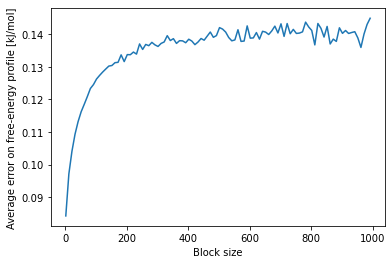

In [11]:
# import err.blocks file into pandas dataset
data=plumed.read_as_pandas("Exercise-4/err.blocks")
# plot error as a function of block size
plt.plot(data["bsize"],data["err"])
# x-y axis labels
plt.xlabel("Block size")
plt.ylabel("Average error on free-energy profile [kJ/mol]")

Now we'll run a metadynamics simulation with a bad CV: the phi value

In [12]:
%%bash
# Exercise 5 - bad CV
# create directory for this exercise
mkdir -p Exercise-5/bad_CV; cd Exercise-5/bad_CV
# create PLUMED input file
cat > "plumed.dat" << EOF
# Activate MOLINFO functionalities
MOLINFO STRUCTURE=../../data/diala/dialaA.pdb 
# Compute the backbone dihedral angle phi, defined by atoms C-N-CA-C
# you should use MOLINFO shortcuts
phi: TORSION ATOMS=@phi-2 
# Compute the backbone dihedral angle psi, defined by atoms N-CA-C-N
# here also you should to use MOLINFO shortcuts
psi: TORSION ATOMS=@psi-2 
# Activate well-tempered metadynamics in psi
metad: METAD ARG=psi ...
   # Deposit a Gaussian every 500 time steps, with initial height 
   # equal to 1.2 kJ/mol and bias factor equal to 8 
   PACE=500 HEIGHT=1.2 BIASFACTOR=8 
   # Gaussian width (sigma) should be chosen based on the CV fluctuations in unbiased run 
   SIGMA=0.3 
   # Gaussians will be written to file and also stored on grid 
   FILE=HILLS GRID_MIN=-pi GRID_MAX=pi 
...
# Print both collective variables on COLVAR file every 10 steps
PRINT ARG=phi,psi FILE=COLVAR STRIDE=10   
EOF

# run simulation
gmx mdrun -s ../../data/diala/topolA.tpr -nsteps 10000000 -plumed plumed.dat

                      :-) GROMACS - gmx mdrun, 2019.6 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf   
                           and the project leaders:
        Mark Abraham, Ber

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/usr/local/anaconda3/envs/plumed/lib/libplumedKernel.dylib" +++


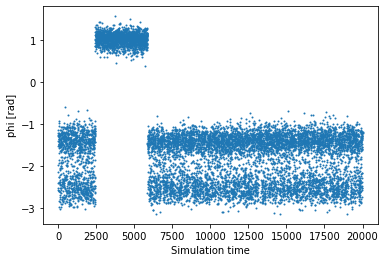

Text(0, 0.5, 'psi [rad]')

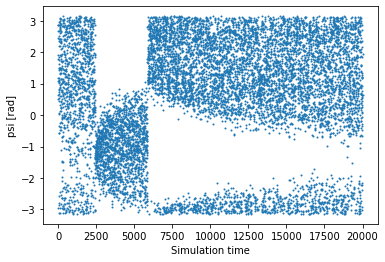

In [13]:
# visualize CV file
data=plumed.read_as_pandas("Exercise-5/bad_CV/COLVAR")
# plot phi during simulation
plt.plot(data["time"][::100],data["phi"][::100],'o', ms=1)
# x-y axis labels
plt.xlabel("Simulation time")
plt.ylabel("phi [rad]")
plt.show()
plt.clf()

plt.plot(data["time"][::100],data["psi"][::100],'o', ms=1)
# x-y axis labels
plt.xlabel("Simulation time")
plt.ylabel("psi [rad]")


***CLASS ACTIVITY***

Lets Repeat our Unbiasing exercises from above and compare the reweighted distributions for phi,psi, and the 2D ramachandran plot.

First we'll reweight the trajetory using the same strategy as beofre


In [14]:
!pwd

/Users/tommysisk/CHEM101/CHEM101.6Exercise-1


In [15]:
%%bash
# Calculate error in free-energy
cd Exercise-5/bad_CV

# prepare PLUMED input file for reweighting
cat > "plumed_reweight.dat" << EOF
# Activate MOLINFO functionalities
MOLINFO STRUCTURE=../../data/diala/dialaA.pdb 
# Compute the backbone dihedral angle phi, defined by atoms C-N-CA-C
# you should use MOLINFO shortcuts
phi: TORSION ATOMS=@phi-2 
# Compute the backbone dihedral angle psi, defined by atoms N-CA-C-N
# here also you should to use MOLINFO shortcuts
psi: TORSION ATOMS=@psi-2 
# Activate well-tempered metadynamics in phi
metad: METAD ARG=psi ...
   # Deposit a Gaussian every 10000000 time steps (never!), with initial height equal to 0.0 kJ/mol 
   PACE=10000000 HEIGHT=0.0 BIASFACTOR=8# <- this is the new stuff! 
   # Gaussian width (sigma) should be chosen based on the CV fluctuations in unbiased run 
   SIGMA=0.3 
   # Gaussians will be written to file and also stored on grid 
   FILE=HILLS GRID_MIN=-pi GRID_MAX=pi
   # Say that METAD should be restarting (= reading an existing HILLS file) 
   RESTART=YES # <- this is the new stuff! 
...

# Print out the values of phi, psi and the metadynamics bias potential
PRINT ARG=phi,psi,metad.bias FILE=COLVAR_REWEIGHT STRIDE=1 # <- also change this one!
EOF

# analyze with PLUMED driver
plumed driver --mf_xtc traj_comp.xtc --plumed plumed_reweight.dat --kt 2.494339



DRIVER: Found molfile format trajectory xtc with name traj_comp.xtc
PLUMED: PLUMED is starting
PLUMED: Version: 2.7.3 (git: Unknown) compiled on Dec  1 2021 at 12:56:28
PLUMED: Please cite these papers when using PLUMED [1][2]
PLUMED: For further information see the PLUMED web page at http://www.plumed.org
PLUMED: Root: /usr/local/anaconda3/envs/plumed/lib/plumed
PLUMED: For installed feature, see /usr/local/anaconda3/envs/plumed/lib/plumed/src/config/config.txt
PLUMED: Molecular dynamics engine: driver
PLUMED: Precision of reals: 8
PLUMED: Running over 1 node
PLUMED: Number of threads: 1
PLUMED: Cache line size: 512
PLUMED: Number of atoms: 22
PLUMED: File suffix: 
PLUMED: FILE: plumed_reweight.dat
PLUMED: Action MOLINFO
PLUMED:   with label @0
PLUMED:   pdb file named ../../data/diala/dialaA.pdb contains 1 chains 
PLUMED:   chain named   contains residues 1 to 3 and atoms 1 to 22 
PLUMED: Action TORSION
PLUMED:   with label phi
PLUMED:   between atoms 5 7 9 15
PLUMED:   using period

In [20]:
#Use the results from COLVAR_REWEIGHT to compare the unbiased and biased distributions of phi, psi, and phi vs. psi
cv_5 = plumed.read_as_pandas("/Users/tommysisk/CHEM101/CHEM101.6Exercise-1/Exercise-5/bad_CV/COLVAR")
cv_5_rw = plumed.read_as_pandas("/Users/tommysisk/CHEM101/CHEM101.6Exercise-1/Exercise-5/bad_CV/COLVAR_REWEIGHT")
cv_5_arr = cv_5.to_numpy()
cv_5_rw_arr = cv_5_rw.to_numpy()

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/usr/local/anaconda3/envs/plumed/lib/libplumedKernel.dylib" +++
+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/usr/local/anaconda3/envs/plumed/lib/libplumedKernel.dylib" +++


In [17]:
import pyemma 

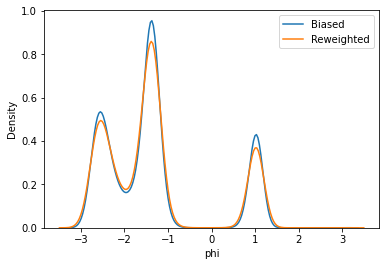

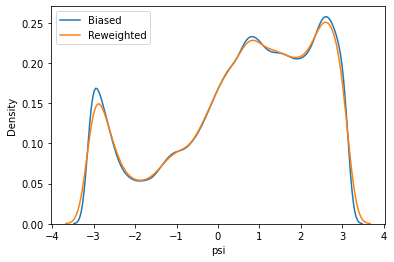

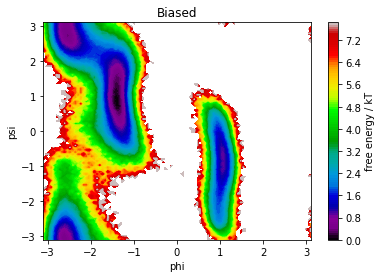

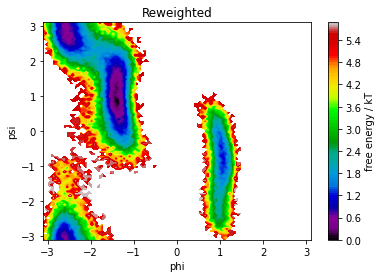

In [35]:
import seaborn as sns
for i,j in zip([1,2],["phi","psi"]):
    fig,ax = plt.subplots(1,1)
    sns.kdeplot(cv_5_arr[:,i],label="Biased",ax=ax)
    sns.kdeplot(cv_5_rw_arr[:,i],label="Reweighted",ax=ax)
    ax.set_xlabel(f"{j}")
    plt.legend()
        
for i,j in zip([cv_5_arr,cv_5_rw_arr],["Biased","Reweighted"]):
    fig,ax = plt.subplots(1,1)
    pyemma.plots.plot_free_energy(*i[:,1:].T,ax=ax)
    ax.set_xlabel("phi")
    ax.set_ylabel("psi")
    ax.set_title(f"{j}")

Lets Follow The PLUMED Recipe to Compute Error Bars

In [36]:
!pwd

/Users/tommysisk/CHEM101/CHEM101.6Exercise-1


In [127]:
%%bash 
cd Exercise-5/bad_CV/
bmax=`sort -n -k 4 COLVAR_REWEIGHT  | tail -n 1 | awk '{print $4}'`
# create phi.weight file
awk '{if($1!="#!") print $2,exp(($4-bm)/2.494339)}' bm=$bmax COLVAR_REWEIGHT > phi.weight

# and now do block analysis with block sizes from 1 to 5000 (every 50)
# create PLUMED-like header for output file
echo "#! FIELDS bsize err" > err.blocks
for i in `seq 1 50 5000`
do
 # run the python script
 python ../../data/do_block_fes.py phi.weight 1 -3.141593 3.141593 50 2.494339 $i
 # calculate average error along the free-energy profile (remove Inf)
 grep -v Inf fes.$i.dat | awk 'BEGIN{tot=0}{tot+=$3}END{print i,tot/NR}' i=$i
done >> err.blocks
cd ../../

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/usr/local/anaconda3/envs/plumed/lib/libplumedKernel.dylib" +++


Text(0, 0.5, 'Average error on free-energy profile [kJ/mol]')

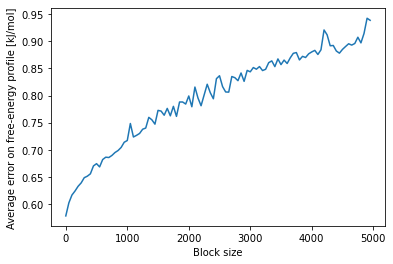

In [128]:
# import err.blocks file into pandas dataset
data=plumed.read_as_pandas("Exercise-5/bad_CV/err.blocks")
# plot error as a function of block size
plt.plot(data["bsize"],data["err"])
# x-y axis labels
plt.xlabel("Block size")
plt.ylabel("Average error on free-energy profile [kJ/mol]")

***HOMEWORK PROBLEM***

Lets run at least 2 more Metadynamics simulations, one attempting to find another bad CV, and another attempting to find a good CV.

Our Strategy for this will be to examine the distributions of descriptions of potential CVs between our different states, and try to develop CV that effectively discriminates the two states, and one that does not.

We can see what CVs are available to see us on the PLUMED Documentation. 

https://www.plumed.org/doc-v2.7/user-doc/html/colvarintro.html

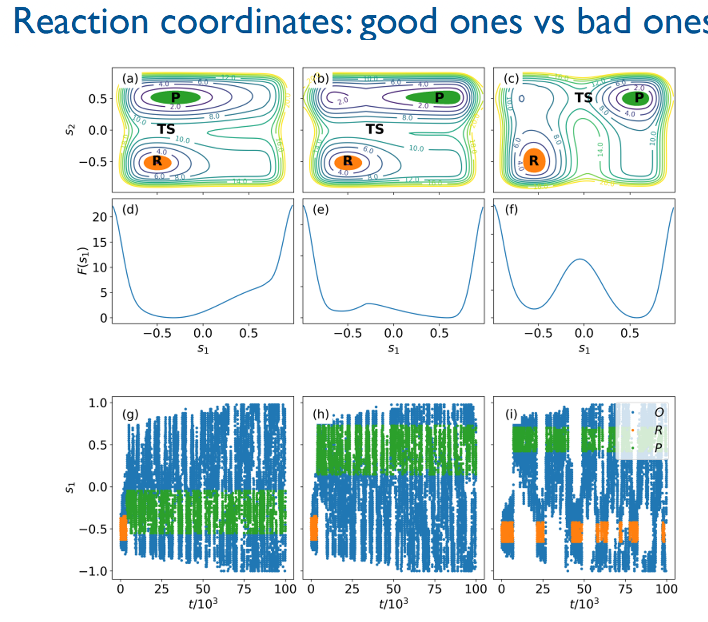

Here is an example of a CV that works as a function of the RMSD from states A+B 

Not the function FUNC=x+y is just to give you an example of the syntax

In [42]:
%%bash
# Exercise 5 - good CV
# create directory for this exercise
mkdir -p Exercise-5/good_CV; cd Exercise-5/good_CV
# create PLUMED input file
cat > "plumed.dat" << EOF
# Activate MOLINFO functionalities
MOLINFO STRUCTURE=../../data/diala/dialaA.pdb 
# Compute the backbone dihedral angle phi, defined by atoms C-N-CA-C
# you should use MOLINFO shortcuts
phi: TORSION ATOMS=@phi-2
# Compute the backbone dihedral angle psi, defined by atoms N-CA-C-N
# here also you should to use MOLINFO shortcuts
psi: TORSION ATOMS=@psi-2
# the difference between the two structures is 0.116584 nm
rA: RMSD REFERENCE=../../data/diala/sA.pdb TYPE=OPTIMAL
rB: RMSD REFERENCE=../../data/diala/sB.pdb TYPE=OPTIMAL
# define progression CV
s: CUSTOM ARG=rA,rB VAR=x,y PERIODIC=NO FUNC=x+y
# Activate well-tempered metadynamics in phi
metad: METAD ARG=s ...
  # Deposit a Gaussian every 500 time steps, with initial height
  # equal to 1.2 kJ/mol and bias factor equal to 8
  PACE=500 HEIGHT=1.2 BIASFACTOR=8
  # Gaussian width (sigma) should be chosen based on the CV fluctuations in unbiased run
  # try 1/2 or 1/3 of the estimated fluctuations
  SIGMA=0.05
  # Gaussians will be written to file and also stored on grid
  FILE=HILLS GRID_MIN=0 GRID_MAX=3
...
# Print both collective variables on COLVAR file every 10 steps
PRINT ARG=phi,psi,rA,rB,s FILE=COLVAR STRIDE=10
EOF

***DEVELOP A NEW BAD CV AND A NEW GOOD CV AND RUN METADYNAMICS WITH THESE CVS***

It might be helpful to load a trajectory that samples both states with MDtraj and try to find functions of RMSD that can differentate the two states
You can also look for any other combination of Distances, Angles or Dihedrals as well

Below is an example of another poor CV, FUNC=rmsdA+rmsdB

In [43]:
%%bash
# Exercise 6 - good CV
# create directory for this exercise
mkdir -p Exercise-6/new_CV; cd Exercise-6/new_CV
# create PLUMED input file
cat > "plumed.dat" << EOF
# Activate MOLINFO functionalities
MOLINFO STRUCTURE=../../data/diala/dialaA.pdb 
# Compute the backbone dihedral angle phi, defined by atoms C-N-CA-C
# you should use MOLINFO shortcuts
phi: TORSION ATOMS=@phi-2
# Compute the backbone dihedral angle psi, defined by atoms N-CA-C-N
# here also you should to use MOLINFO shortcuts
psi: TORSION ATOMS=@psi-2
# the difference between the two structures is 0.116584 nm
rA: RMSD REFERENCE=../../data/diala/sA.pdb TYPE=OPTIMAL
rB: RMSD REFERENCE=../../data/diala/sB.pdb TYPE=OPTIMAL
# define progression CV
s: CUSTOM ARG=rA,rB VAR=x,y PERIODIC=NO FUNC=x+y
# Activate well-tempered metadynamics in phi
metad: METAD ARG=s ...
  # Deposit a Gaussian every 500 time steps, with initial height
  # equal to 1.2 kJ/mol and bias factor equal to 8
  PACE=500 HEIGHT=1.2 BIASFACTOR=8
  # Gaussian width (sigma) should be chosen based on the CV fluctuations in unbiased run
  # try 1/2 or 1/3 of the estimated fluctuations
  SIGMA=0.05
  # Gaussians will be written to file and also stored on grid
  FILE=HILLS GRID_MIN=0 GRID_MAX=3
...
# Print both collective variables on COLVAR file every 10 steps
PRINT ARG=phi,psi,rA,rB,s FILE=COLVAR STRIDE=10
EOF

# run simulation
gmx mdrun -s ../../data/diala/topolA.tpr -nsteps 10000000 -plumed plumed.dat

                      :-) GROMACS - gmx mdrun, 2019.6 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf   
                           and the project leaders:
        Mark Abraham, Ber

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/usr/local/anaconda3/envs/plumed/lib/libplumedKernel.dylib" +++


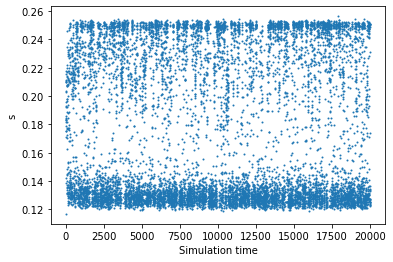

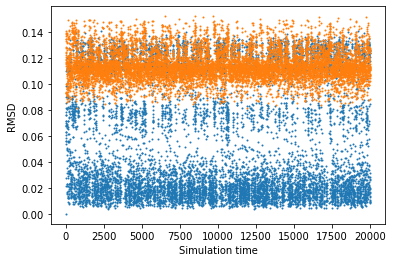

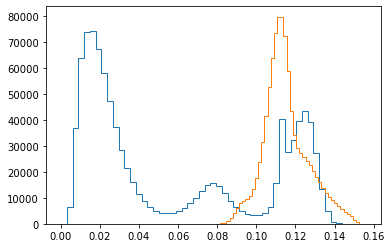

In [44]:
# visualize CV file
data=plumed.read_as_pandas("Exercise-6/new_CV/COLVAR")
# plot the s-path variable during the simulation
plt.plot(data["time"][::100],data["s"][::100],'o', ms=1)
# x-y axis labels
plt.xlabel("Simulation time")
plt.ylabel("s")
plt.show()
plt.clf()

# plot the s-path variable during the simulation
plt.plot(data["time"][::100],data["rA"][::100],'o', ms=1,label='rA')
plt.plot(data["time"][::100],data["rB"][::100],'o', ms=1,label='rB')
# x-y axis labels
plt.xlabel("Simulation time")
plt.ylabel("RMSD")
plt.show()
plt.clf

plt.hist(data["rA"],bins=50,histtype='step')
plt.hist(data["rB"],bins=50,histtype='step')
plt.show()

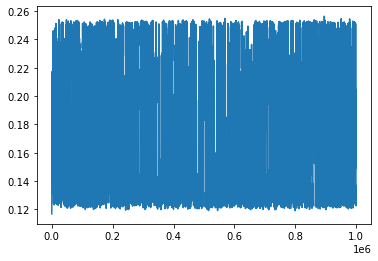

In [45]:
x=data["rA"][::100]
y=data["rB"][::100]
f=x+y
plt.plot(f)

Text(0, 0.5, 'phi [rad]')

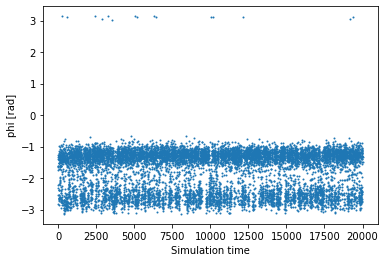

In [46]:
# plot phi during the simulation
plt.plot(data["time"][::100],data["phi"][::100],'o', ms=1)
# x-y axis labels
plt.xlabel("Simulation time")
plt.ylabel("phi [rad]")

Text(0, 0.5, 'psi [rad]')

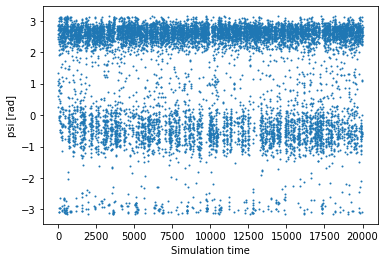

In [47]:
# plot phi during the simulation
plt.plot(data["time"][::100],data["psi"][::100],'o', ms=1)
# x-y axis labels
plt.xlabel("Simulation time")
plt.ylabel("psi [rad]")

In [48]:
%%bash
# Calculate error in free-energy
cd Exercise-6/new_CV

# prepare PLUMED input file for reweighting
cat > "plumed_reweight.dat" << EOF
# Activate MOLINFO functionalities
MOLINFO STRUCTURE=../../data/diala/dialaA.pdb 
# Compute the backbone dihedral angle phi, defined by atoms C-N-CA-C
# you should use MOLINFO shortcuts
phi: TORSION ATOMS=@phi-2
# Compute the backbone dihedral angle psi, defined by atoms N-CA-C-N
# here also you should to use MOLINFO shortcuts
psi: TORSION ATOMS=@psi-2
# the difference between the two structures is 0.116584 nm
rA: RMSD REFERENCE=../../data/diala/sA.pdb TYPE=OPTIMAL
rB: RMSD REFERENCE=../../data/diala/sB.pdb TYPE=OPTIMAL
# define progression CV
s: CUSTOM ARG=rA,rB VAR=x,y PERIODIC=NO FUNC=x+y
# Activate well-tempered metadynamics in phi
metad: METAD ARG=s ...
   # Deposit a Gaussian every 10000000 time steps (never!), with initial height equal to 0.0 kJ/mol 
   PACE=10000000 HEIGHT=0.0 BIASFACTOR=8# <- this is the new stuff! 
   # Gaussian width (sigma) should be chosen based on the CV fluctuations in unbiased run 
   SIGMA=0.05
   # Gaussians will be written to file and also stored on grid
   FILE=HILLS GRID_MIN=0 GRID_MAX=3
   # Say that METAD should be restarting (= reading an existing HILLS file) 
   RESTART=YES # <- this is the new stuff! 
...
# Print out the values of phi, psi and the metadynamics bias potential
PRINT ARG=phi,psi,rA,rB,s,metad.bias FILE=COLVAR_REWEIGHT STRIDE=1 # <- also change this one!
EOF

# analyze with PLUMED driver
plumed driver --mf_xtc traj_comp.xtc --plumed plumed_reweight.dat --kt 2.494339

# create phi.weight file with phi and weight from COLVAR_REWEIGHT
# find maximum of bias
bmax=`sort -n -k 4 COLVAR_REWEIGHT  | tail -n 1 | awk '{print $4}'`
# create phi.weight file
awk '{if($1!="#!") print $2,exp(($4-bm)/2.494339)}' bm=$bmax COLVAR_REWEIGHT > phi.weight

# and now do block analysis with block sizes from 1 to 5000 (every 50)
# create PLUMED-like header for output file
echo "#! FIELDS bsize err" > err.blocks
for i in `seq 1 50 5000`
do
 # run the python script
 python ../../data/do_block_fes.py phi.weight 1 -3.141593 3.141593 50 2.494339 $i
 # calculate average error along the free-energy profile (remove Inf)
 grep -v Inf fes.$i.dat | awk 'BEGIN{tot=0}{tot+=$3}END{print i,tot/NR}' i=$i
done >> err.blocks


DRIVER: Found molfile format trajectory xtc with name traj_comp.xtc
PLUMED: PLUMED is starting
PLUMED: Version: 2.7.3 (git: Unknown) compiled on Dec  1 2021 at 12:56:28
PLUMED: Please cite these papers when using PLUMED [1][2]
PLUMED: For further information see the PLUMED web page at http://www.plumed.org
PLUMED: Root: /usr/local/anaconda3/envs/plumed/lib/plumed
PLUMED: For installed feature, see /usr/local/anaconda3/envs/plumed/lib/plumed/src/config/config.txt
PLUMED: Molecular dynamics engine: driver
PLUMED: Precision of reals: 8
PLUMED: Running over 1 node
PLUMED: Number of threads: 1
PLUMED: Cache line size: 512
PLUMED: Number of atoms: 22
PLUMED: File suffix: 
PLUMED: FILE: plumed_reweight.dat
PLUMED: Action MOLINFO
PLUMED:   with label @0
PLUMED:   pdb file named ../../data/diala/dialaA.pdb contains 1 chains 
PLUMED:   chain named   contains residues 1 to 3 and atoms 1 to 22 
PLUMED: Action TORSION
PLUMED:   with label phi
PLUMED:   between atoms 5 7 9 15
PLUMED:   using period

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/usr/local/anaconda3/envs/plumed/lib/libplumedKernel.dylib" +++


Text(0, 0.5, 'Average error on free-energy profile [kJ/mol]')

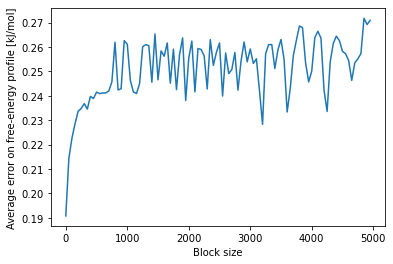

In [49]:
# import err.blocks file into pandas dataset
data=plumed.read_as_pandas("Exercise-6/new_CV/err.blocks")
# plot error as a function of block size
plt.plot(data["bsize"],data["err"])
# x-y axis labels
plt.xlabel("Block size")
plt.ylabel("Average error on free-energy profile [kJ/mol]")

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/usr/local/anaconda3/envs/plumed/lib/libplumedKernel.dylib" +++


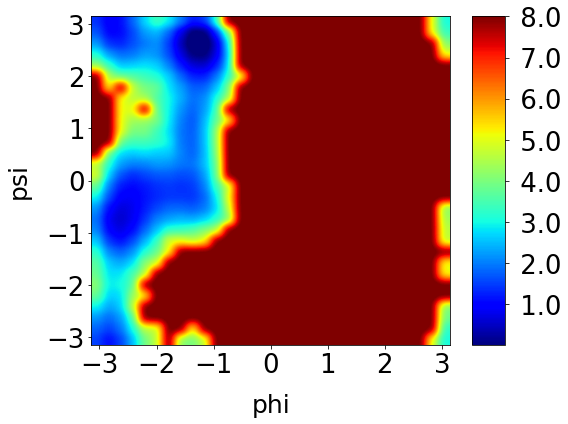

<Figure size 432x288 with 0 Axes>

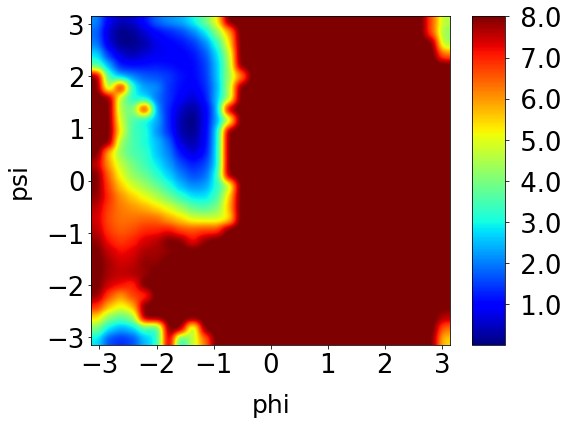

<Figure size 432x288 with 0 Axes>

In [52]:
# plot final fes
data_r=plumed.read_as_pandas("Exercise-6/new_CV/COLVAR_REWEIGHT")

bias=data_r["metad.bias"]
kt=2.494339
w=np.exp(bias/kt)

#Lets Look at The Biased and Unbiased Distributions of the Dihedral Angles
dG,xedges,yedges=free_energy(data_r["psi"],data_r["phi"], 300, -3.14, 3.14, -3.14, 3.14)

fig = plt.figure(figsize=(8, 6))
im = plt.imshow(dG, interpolation='gaussian', extent=[
                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')
cbar_ticks = [0, 1, 2, 3, 4, 5,6,7,8]
plt.xlim(-3.14,3.14)
plt.ylim(-3.14,3.14)

cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'),
                  aspect=10)  # grab the Colorbar instance
imaxes = plt.gca()
plt.ylabel("psi", size=25, labelpad=15)
plt.xlabel("phi", size=25, labelpad=15)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.xticks(size='26')
plt.yticks(size='26')
plt.axes(cb.ax)
plt.clim(vmin=0.01, vmax=8.0)
plt.yticks(size='26')
plt.tight_layout()
plt.show()
plt.clf()

def free_energy_weights(a, b, T, y0, ymax, x0, xmax,w):
    free_energy, xedges, yedges = np.histogram2d(
        a, b, 30, [[y0, ymax], [x0, xmax]], normed=True, weights=w)
    free_energy = np.log(np.flipud(free_energy)+.000001)
    free_energy = -(0.001987*T)*free_energy
    return free_energy, xedges, yedges

dG,xedges,yedges=free_energy_weights(data_r["psi"],data_r["phi"], 300, -3.14, 3.14, -3.14, 3.14,w)
fig = plt.figure(figsize=(8, 6))
im = plt.imshow(dG, interpolation='gaussian', extent=[
                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')
cbar_ticks = [0, 1, 2, 3, 4, 5,6,7,8]
plt.xlim(-3.14,3.14)
plt.ylim(-3.14,3.14)

cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'),
                  aspect=10)  # grab the Colorbar instance
imaxes = plt.gca()
plt.ylabel("psi", size=25, labelpad=15)
plt.xlabel("phi", size=25, labelpad=15)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.xticks(size='26')
plt.yticks(size='26')
plt.axes(cb.ax)
plt.clim(vmin=0.01, vmax=8.0)
plt.yticks(size='26')
plt.tight_layout()
plt.show()
plt.clf()



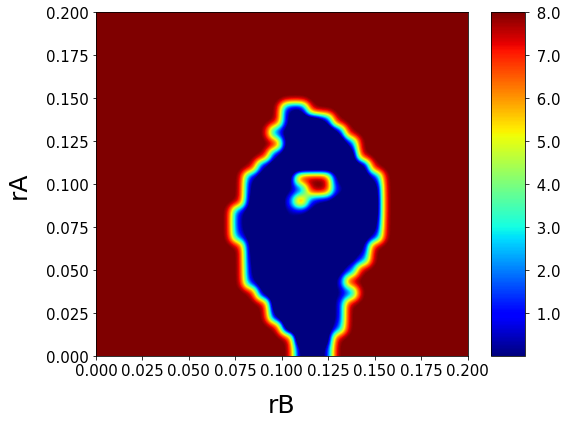

<Figure size 432x288 with 0 Axes>

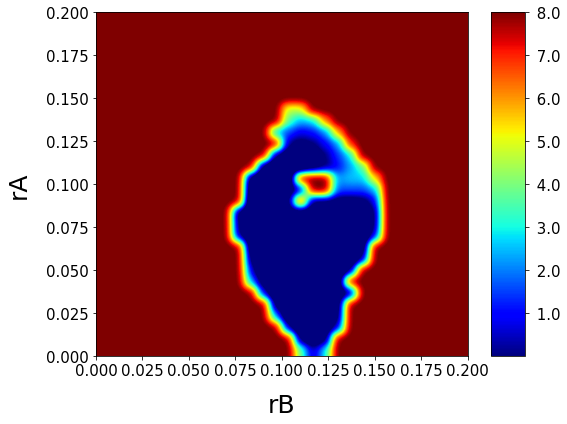

<Figure size 432x288 with 0 Axes>

In [53]:
#Lets Look at The Biased and Unbiased Distributions of the Dihedral Angles
dG,xedges,yedges=free_energy(data_r["rA"],data_r["rB"], 300, 0, 0.2, 0,.2)

fig = plt.figure(figsize=(8, 6))
im = plt.imshow(dG, interpolation='gaussian', extent=[
                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')
cbar_ticks = [0, 1, 2, 3, 4, 5,6,7,8]
plt.xlim(0,.2)
plt.ylim(0,.2)

cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'),
                  aspect=10)  # grab the Colorbar instance
imaxes = plt.gca()
plt.ylabel("rA", size=25, labelpad=15)
plt.xlabel("rB", size=25, labelpad=15)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.xticks(size='15')
plt.yticks(size='15')
plt.axes(cb.ax)
plt.clim(vmin=0.01, vmax=8.0)
plt.yticks(size='15')
plt.tight_layout()
plt.show()
plt.clf()

def free_energy_weights(a, b, T, y0, ymax, x0, xmax,w):
    free_energy, xedges, yedges = np.histogram2d(
        a, b, 30, [[y0, ymax], [x0, xmax]], normed=True, weights=w)
    free_energy = np.log(np.flipud(free_energy)+.000001)
    free_energy = -(0.001987*T)*free_energy
    return free_energy, xedges, yedges

dG,xedges,yedges=free_energy_weights(data_r["rA"],data_r["rB"], 300, 0, 0.2, 0,.2,w)
fig = plt.figure(figsize=(8, 6))
im = plt.imshow(dG, interpolation='gaussian', extent=[
                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')
cbar_ticks = [0, 1, 2, 3, 4, 5,6,7,8]
plt.xlim(0,0.2)
plt.ylim(0,0.2)

cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'),
                  aspect=10)  # grab the Colorbar instance
imaxes = plt.gca()
plt.ylabel("rA", size=25, labelpad=15)
plt.xlabel("rB", size=25, labelpad=15)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.xticks(size='15')
plt.yticks(size='15')
plt.axes(cb.ax)
plt.clim(vmin=0.01, vmax=8.0)
plt.yticks(size='15')
plt.tight_layout()
plt.show()
plt.clf()

In [ ]:
#good CV - PCV var in dihedral spce

In [270]:
%%bash
# here is an example of a PCAVAR, doting the dihedrals with vector connecting the two basins
mkdir -p Exercise-8/new_CV; cd Exercise-8/new_CV
rm -rf *COLVAR*
# create PLUMED input file
cat > "plumed.dat" << EOF
# Activate MOLINFO functionalities
MOLINFO STRUCTURE=../../data/diala/dialaA.pdb 
# Compute the backbone dihedral angle phi, defined by atoms C-N-CA-C
# you should use MOLINFO shortcuts
phi: TORSION ATOMS=@phi-2
# Compute the backbone dihedral angle psi, defined by atoms N-CA-C-N
# here also you should to use MOLINFO shortcuts
psi: TORSION ATOMS=@psi-2
# the difference between the two structures is 0.116584 nm
#rA: RMSD REFERENCE=../../data/diala/sA.pdb TYPE=OPTIMAL
#rB: RMSD REFERENCE=../../data/diala/sB.pdb TYPE=OPTIMAL
# define progression CV
s: CUSTOM ARG=phi,psi VAR=x,y PERIODIC=NO FUNC=2.621915*x+-2.408714*y
# Activate well-tempered metadynamics in phi
metad: METAD ARG=s ...
  # Deposit a Gaussian every 500 time steps, with initial height
  # equal to 1.2 kJ/mol and bias factor equal to 8
  PACE=500 HEIGHT=1.2 BIASFACTOR=8
  # Gaussian width (sigma) should be chosen based on the CV fluctuations in unbiased run
  # try 1/2 or 1/3 of the estimated fluctuations
  SIGMA=0.05
  # Gaussians will be written to file and also stored on grid
  FILE=HILLS GRID_MIN=-25 GRID_MAX=25
...
# Print both collective variables on COLVAR file every 10 steps
PRINT ARG=phi,psi,s FILE=COLVAR STRIDE=10
EOF

# run simulation
gmx mdrun -s ../../data/diala/topolA.tpr -nsteps 1000000 -plumed plumed.dat

                      :-) GROMACS - gmx mdrun, 2019.6 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf   
                           and the project leaders:
        Mark Abraham, Ber

In [268]:
!find "$(pwd)" | grep COLVAR

/Users/tommysisk/CHEM101/CHEM101.6Exercise-1/Exercise-3/COLVAR_REWEIGHT
/Users/tommysisk/CHEM101/CHEM101.6Exercise-1/Exercise-2/COLVAR
/Users/tommysisk/CHEM101/CHEM101.6Exercise-1/Exercise-5/bad_CV/COLVAR_REWEIGHT
/Users/tommysisk/CHEM101/CHEM101.6Exercise-1/Exercise-5/bad_CV/COLVAR
/Users/tommysisk/CHEM101/CHEM101.6Exercise-1/Exercise-8/new_CV/COLVAR
/Users/tommysisk/CHEM101/CHEM101.6Exercise-1/Exercise-6/new_CV/COLVAR_REWEIGHT
/Users/tommysisk/CHEM101/CHEM101.6Exercise-1/Exercise-6/new_CV/COLVAR
/Users/tommysisk/CHEM101/CHEM101.6Exercise-1/Exercise-1/run_B/COLVAR
/Users/tommysisk/CHEM101/CHEM101.6Exercise-1/Exercise-1/run_A/COLVAR


+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/usr/local/anaconda3/envs/plumed/lib/libplumedKernel.dylib" +++


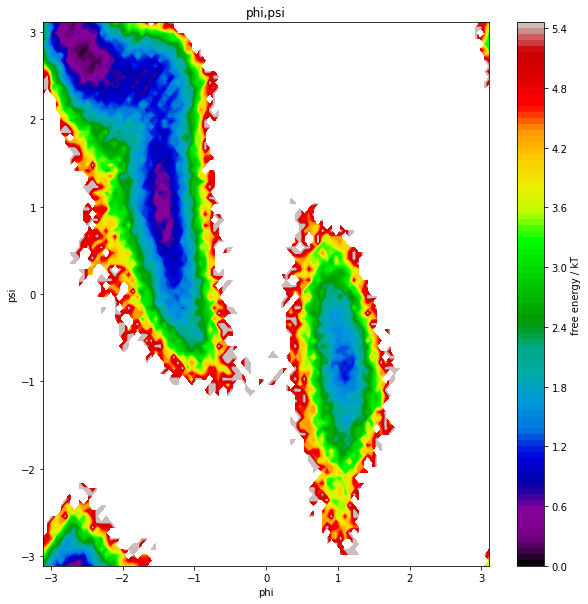

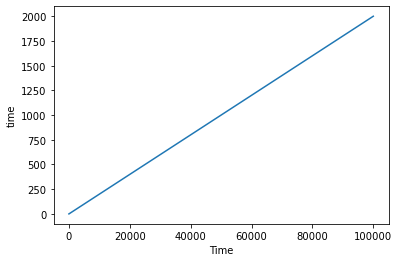

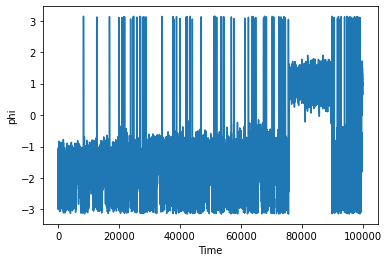

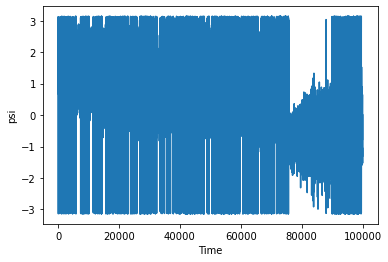

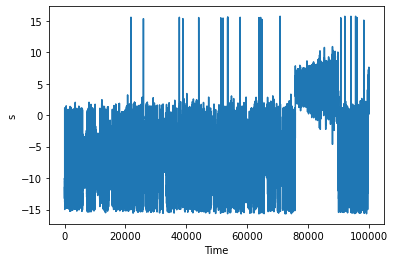

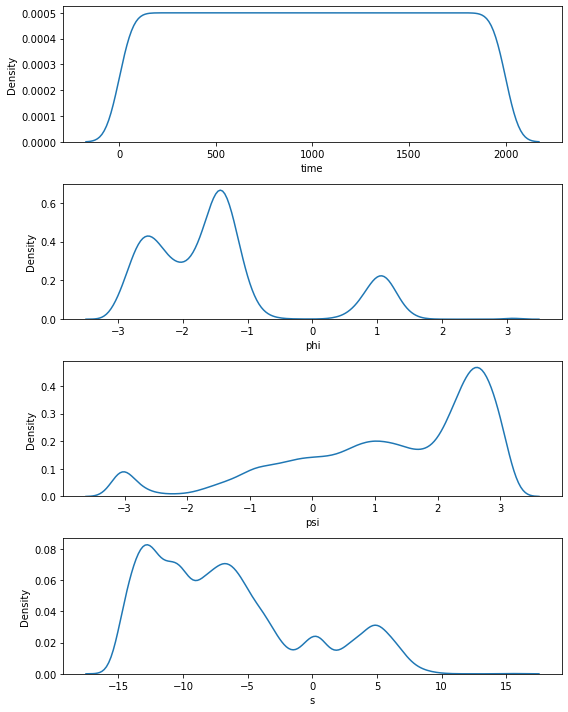

In [272]:
##plots for PCA VAR in dihedral space metady simulation


_,_,_=plotmed(["/Users/tommysisk/CHEM101/CHEM101.6Exercise-1/Exercise-8/new_CV/COLVAR"])

In [ ]:
#bad CV - distance between atoms 1 and 12

In [274]:
%%bash
# here is an example of a PCAVAR, doting the dihedrals with vector connecting the two basins
mkdir -p Exercise-9/new_CV; cd Exercise-9/new_CV
rm -rf *COLVAR*
# create PLUMED input file
cat > "plumed.dat" << EOF
# Activate MOLINFO functionalities
MOLINFO STRUCTURE=../../data/diala/dialaA.pdb 
# Compute the backbone dihedral angle phi, defined by atoms C-N-CA-C
# you should use MOLINFO shortcuts
phi: TORSION ATOMS=@phi-2
# Compute the backbone dihedral angle psi, defined by atoms N-CA-C-N
# here also you should to use MOLINFO shortcuts
psi: TORSION ATOMS=@psi-2
# the difference between the two structures is 0.116584 nm
#rA: RMSD REFERENCE=../../data/diala/sA.pdb TYPE=OPTIMAL
#rB: RMSD REFERENCE=../../data/diala/sB.pdb TYPE=OPTIMAL
# define progression CV
s: DISTANCE ATOMS=1,12
# Activate well-tempered metadynamics in phi
metad: METAD ARG=s ...
  # Deposit a Gaussian every 500 time steps, with initial height
  # equal to 1.2 kJ/mol and bias factor equal to 8
  PACE=500 HEIGHT=1.2 BIASFACTOR=8
  # Gaussian width (sigma) should be chosen based on the CV fluctuations in unbiased run
  # try 1/2 or 1/3 of the estimated fluctuations
  SIGMA=0.05
  # Gaussians will be written to file and also stored on grid
  FILE=HILLS GRID_MIN=-25 GRID_MAX=25
...
# Print both collective variables on COLVAR file every 10 steps
PRINT ARG=phi,psi,s FILE=COLVAR STRIDE=10
EOF

# run simulation
gmx mdrun -s ../../data/diala/topolA.tpr -nsteps 1000000 -plumed plumed.dat

                      :-) GROMACS - gmx mdrun, 2019.6 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf   
                           and the project leaders:
        Mark Abraham, Ber

In [275]:
!find "$(pwd)" | grep COLVAR

/Users/tommysisk/CHEM101/CHEM101.6Exercise-1/Exercise-3/COLVAR_REWEIGHT
/Users/tommysisk/CHEM101/CHEM101.6Exercise-1/Exercise-2/COLVAR
/Users/tommysisk/CHEM101/CHEM101.6Exercise-1/Exercise-5/bad_CV/COLVAR_REWEIGHT
/Users/tommysisk/CHEM101/CHEM101.6Exercise-1/Exercise-5/bad_CV/COLVAR
/Users/tommysisk/CHEM101/CHEM101.6Exercise-1/Exercise-9/new_CV/COLVAR
/Users/tommysisk/CHEM101/CHEM101.6Exercise-1/Exercise-8/new_CV/COLVAR
/Users/tommysisk/CHEM101/CHEM101.6Exercise-1/Exercise-6/new_CV/COLVAR_REWEIGHT
/Users/tommysisk/CHEM101/CHEM101.6Exercise-1/Exercise-6/new_CV/COLVAR
/Users/tommysisk/CHEM101/CHEM101.6Exercise-1/Exercise-1/run_B/COLVAR
/Users/tommysisk/CHEM101/CHEM101.6Exercise-1/Exercise-1/run_A/COLVAR


+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/usr/local/anaconda3/envs/plumed/lib/libplumedKernel.dylib" +++


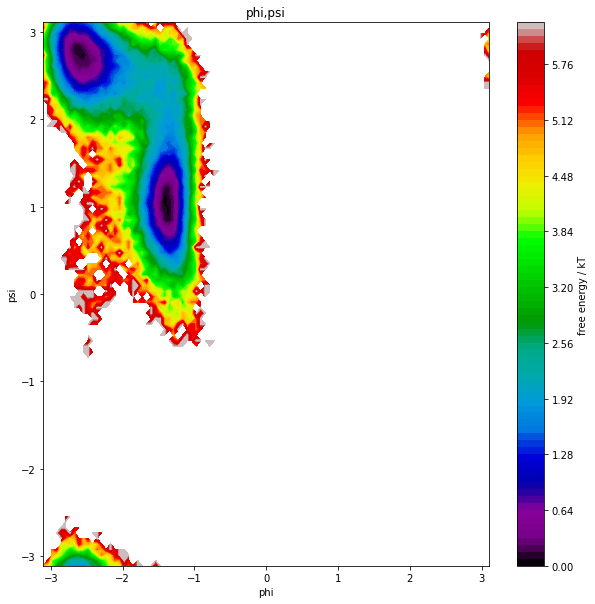

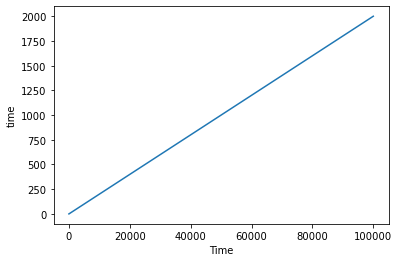

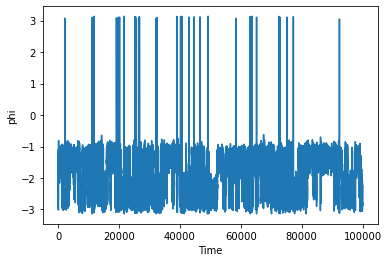

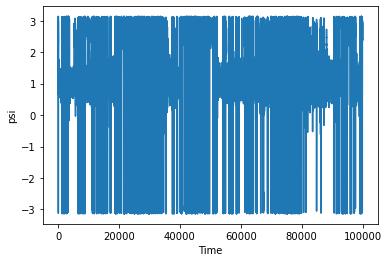

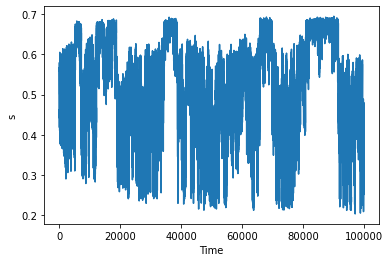

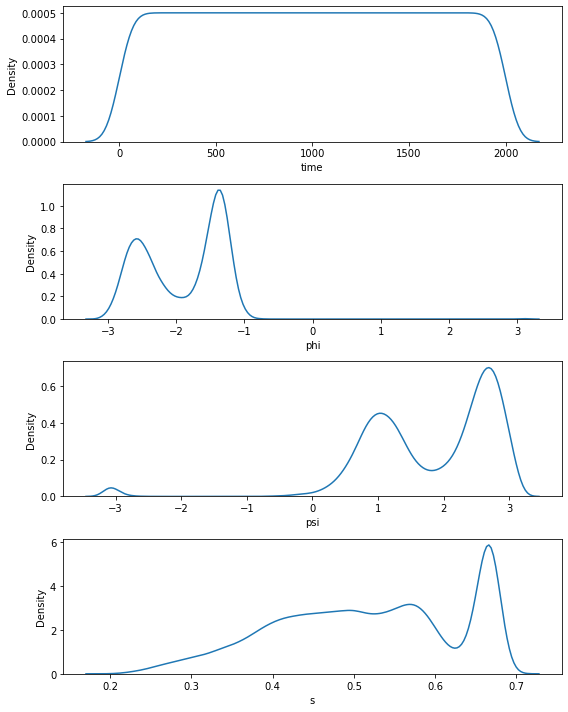

In [276]:
##plots for CV distance atoms 1,12 metady simulation


_,_,_=plotmed(["/Users/tommysisk/CHEM101/CHEM101.6Exercise-1/Exercise-9/new_CV/COLVAR"])

In [277]:
!pwd

/Users/tommysisk/CHEM101/CHEM101.6Exercise-1


In [ ]:
/CHEM101.6/CHEM101.6_Project5_MetaDynamics_aladipeptide_student.ipynb